## Import

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import gc
import os, requests

from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

PRJ_DIR = os.getcwd()
DATA_DIR = os.path.join(PRJ_DIR, 'data')

print(PRJ_DIR)
print(DATA_DIR)

/data/jupyter_dir/docvqa/steve/traffic
/data/jupyter_dir/docvqa/steve/traffic/data


## csv to parquet
#### -> 메모리에 효율적인 데이터 유형을 사용하여 용량을 크게 줄이고 빠른 작업이 가능합니다.

In [4]:
def csv_to_parquet(csv_name, save_name):
    df = pd.read_csv(os.path.join(DATA_DIR, f'{csv_name}.csv'))
    df.to_parquet(os.path.join(DATA_DIR, f'{save_name}.parquet'))
    del df
    gc.collect()
    print(save_name, 'Done.')

In [6]:
csv_to_parquet('train', 'train')
csv_to_parquet('test', 'test')

train Done.
test Done.


## 데이터 불러오기

In [2]:
train = pd.read_parquet(os.path.join(DATA_DIR, 'train.parquet'))
test = pd.read_parquet(os.path.join(DATA_DIR, 'test.parquet'))

In [3]:
train.shape, test.shape

((4701217, 24), (291241, 23))

## 분석에서 제외  
#### -> 'road_in_use', 'vehicle_restricted', 'height_restricted' 

In [4]:
train_desc = train.describe().transpose()
train_desc[train_desc['std']==0].index

Index(['vehicle_restricted', 'height_restricted'], dtype='object')

In [5]:
train = train.drop(columns=['road_in_use', 'vehicle_restricted', 'height_restricted'])
test = test.drop(columns=['road_in_use', 'vehicle_restricted', 'height_restricted'])
train.shape, test.shape

((4701217, 21), (291241, 20))

# 결측치 확인

In [6]:
train.isnull().sum()

id                       0
base_date                0
day_of_week              0
base_hour                0
lane_count               0
road_rating              0
road_name                0
multi_linked             0
connect_code             0
maximum_speed_limit      0
weight_restricted        0
road_type                0
start_node_name          0
start_latitude           0
start_longitude          0
start_turn_restricted    0
end_node_name            0
end_latitude             0
end_longitude            0
end_turn_restricted      0
target                   0
dtype: int64

In [7]:
test.isnull().sum()

id                       0
base_date                0
day_of_week              0
base_hour                0
lane_count               0
road_rating              0
road_name                0
multi_linked             0
connect_code             0
maximum_speed_limit      0
weight_restricted        0
road_type                0
start_node_name          0
start_latitude           0
start_longitude          0
start_turn_restricted    0
end_node_name            0
end_latitude             0
end_longitude            0
end_turn_restricted      0
dtype: int64

# 시간 변수

In [12]:
train['base_date'].describe()

count    4.701217e+06
mean     2.021672e+07
std      4.555709e+03
min      2.021090e+07
25%      2.021110e+07
50%      2.022013e+07
75%      2.022050e+07
max      2.022073e+07
Name: base_date, dtype: float64

## 공휴일 
#### -> 공공데이터포털 특일 정보에서 공휴일 데이터를 가져와서 데이터프레임으로 정리
https://www.data.go.kr/data/15012690/openapi.do

In [54]:
holiday = pd.read_csv(os.path.join(DATA_DIR, 'holiday.csv'))
holiday.head()

,date,name
0,20210101,1월1일
1,20210211,설날
2,20210212,설날
3,20210213,설날
4,20210301,삼일절


In [10]:
def create_time_features(data):

    tmp = data.copy()

    tmp['weekend'] = tmp['day_of_week'].map({"월":0, "화":0, "수":0, "목":0, "금":0, "토":1, "일":1})

    tmp['holiday'] = tmp['base_date'].isin(holiday['date'].astype(int)).astype(int)
    tmp['is_holiday'] = (tmp['weekend'] + tmp['holiday']).map({0:0, 1:1, 2:1})
    tmp = tmp.drop(['weekend', 'holiday'], axis=1)
    
    tmp['month'] = tmp['base_date'].astype(str).str[4:6].astype(int)

    return tmp


train = create_time_features(train)
test = create_time_features(test)
train.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,weight_restricted,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,is_holiday,month
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,32400.0,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0,0,6
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,0.0,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0,0,7
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,0.0,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0,1,10
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,0.0,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0,0,3
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,0.0,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0,0,10


# 지리 데이터 (공간 파생변수)

## 위도, 경도 차이

In [12]:
train['lat_change'] = train['start_latitude'] - train['end_latitude']
train['lon_change'] = train['start_longitude'] - train['end_longitude']

test['lat_change'] = test['start_latitude'] - test['end_latitude']
test['lon_change'] = test['start_longitude'] - test['end_longitude']

## 두 지점 사이의 거리

In [13]:
# https://www.kaggle.com/code/speedoheck/calculate-distance-with-geo-coordinates/notebook

from math import radians, cos, sin, asin, sqrt

def haversine(row):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1 = row['start_longitude']
    lat1 = row['start_latitude']
    lon2 = row['end_longitude']
    lat2 = row['end_latitude']

    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km

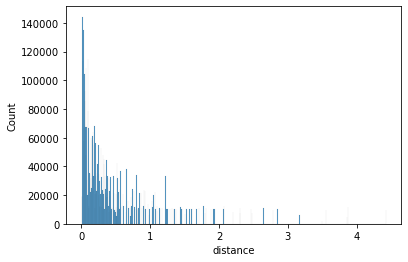

In [14]:
train['distance'] = train.apply(haversine, axis=1)
sns.histplot(data=train, x='distance');

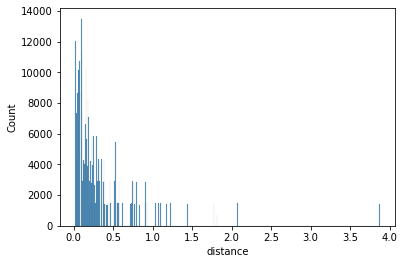

In [15]:
test['distance'] = test.apply(haversine, axis=1)
sns.histplot(data=test, x='distance');

## 제주공항까지 거리

In [16]:
def haversine_airport(row):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1 = 126.4913534
    lat1 = 33.5104135
    lon2 = (row['start_longitude'] + row['end_longitude']) / 2
    lat2 = (row['start_latitude'] + row['end_latitude']) / 2

    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km

train['airport_distance'] = train.apply(haversine_airport, axis=1)
test['airport_distance'] = test.apply(haversine_airport, axis=1)

## 제주도 권역별 구분하여 변수 추가
* 제주시 도심 : 126.4531517 ~ 126.5900257 , 33.4670429 ~ 
* 서귀포 도심 : 126.3972753 ~ 126.6076604 , ~ 33.2686052

In [17]:
# 출발지점 권역
mask_jj_start = (train['start_longitude'] > 126.4531517) & (train['start_longitude']< 126.5900257) & (train['start_latitude'] > 33.4670429)
mask_jj_end = (train['end_longitude'] > 126.4531517) & (train['end_longitude']< 126.5900257) & (train['end_latitude'] > 33.4670429)

mask_sgp_start = (train['start_longitude'] > 126.3972753) & (train['start_longitude']< 126.6076604) & (train['start_latitude'] < 33.2686052)
mask_sgp_end = (train['end_longitude'] > 126.3972753) & (train['end_longitude']< 126.6076604) & (train['end_latitude'] < 33.2686052)

In [18]:
train['center_start'] = 0
test['center_start'] = 0

train.loc[mask_jj_start, 'center_start'] = 1
train.loc[mask_sgp_start, 'center_start'] = 2

test.loc[mask_jj_start, 'center_start'] = 1
test.loc[mask_sgp_start, 'center_start'] = 2

train['center_end'] = 0
test['center_end'] = 0

train.loc[mask_jj_end, 'center_end'] = 1
train.loc[mask_sgp_end, 'center_end'] = 2

test.loc[mask_jj_end, 'center_end'] = 1
test.loc[mask_sgp_end, 'center_end'] = 2

## GPS 정보를 사용해서 road 구분

In [19]:
train['road_code'] = train['start_latitude'].astype(str)+'_'+train['start_longitude'].astype(str)+'_'+train['end_latitude'].astype(str)+'_'+train['end_longitude'].astype(str)
train['road_code'].value_counts()

33.3058672207151_126.599081327413_33.3082357708673_126.598689775097    6477
33.3082357708673_126.598689775097_33.3058672207151_126.599081327413    6397
33.5014774884938_126.569223187609_33.4968633703578_126.58123009621     6077
33.5016270326083_126.568923085567_33.5014774884938_126.569223187609    6077
33.4968633703578_126.58123009621_33.496710616894_126.581529061335      6075
                                                                       ... 
33.26127013848_126.524428741607_33.2574097173209_126.524412034435       744
33.2566709359707_126.52441046863_33.2541529264473_126.524330998601      744
33.2574097173209_126.524412034435_33.2566709359707_126.52441046863      744
33.2574097173209_126.524412034435_33.26127013848_126.524428741607       587
33.2574006381515_126.52574476307_33.2574097173209_126.524412034435      587
Name: road_code, Length: 904, dtype: int64

In [20]:
test['road_code'] = test['start_latitude'].astype(str)+'_'+test['start_longitude'].astype(str)+'_'+test['end_latitude'].astype(str)+'_'+test['end_longitude'].astype(str)
test['road_code'].value_counts()

33.5016270326083_126.568923085567_33.5014774884938_126.569223187609    740
33.5003300857641_126.505998479791_33.5001322103386_126.512046011949    740
33.4666066165642_126.454021511351_33.4681579285437_126.446368636228    740
33.5014774884938_126.569223187609_33.4968633703578_126.58123009621     740
33.2585071159642_126.427003448638_33.2581193973191_126.415839509268    740
                                                                      ... 
33.4383285187565_126.732031757687_33.4526884912095_126.709276573579      7
33.4359411786532_126.736248543312_33.4379464931581_126.73250865826       7
33.4857069297096_126.604162168012_33.4886994919865_126.597620980703      7
33.4471827098691_126.91257888647_33.4441208040702_126.912947762086       7
33.4288406442461_126.750881044473_33.4359411786532_126.736248543312      7
Name: road_code, Length: 441, dtype: int64

#### -> Target Encoding

In [21]:
road_stats = train.groupby(['road_code'])[['target']].agg(['min', 'mean', 'max', 'std']).reset_index()
road_stats.columns = ['road_code', 'road_min', 'road_mean', 'road_max', 'road_std']
train = train.merge(road_stats, how='left', on='road_code')
train.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,weight_restricted,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,is_holiday,month,lat_change,lon_change,distance,airport_distance,center_start,center_end,road_code,road_min,road_mean,road_max,road_std
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,32400.0,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0,0,6,-0.000001,0.000277,0.025694,18.330548,0,0,33.427747274683_126.662612038652_33.4277487730...,16.0,51.756910,72.0,4.587047
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,0.0,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0,0,7,-0.004081,0.002867,0.525560,3.470872,1,1,33.5007304293026_126.529106761554_33.504811303...,5.0,26.400712,59.0,7.102290
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,0.0,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0,1,10,-0.000927,0.006450,0.608016,28.185912,0,0,33.2791450972975_126.368597660936_33.280072104...,32.0,59.101720,88.0,12.091252
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,0.0,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0,0,3,0.000515,0.000976,0.107285,30.222870,2,2,33.2460808686345_126.56720431031_33.2455654004...,2.0,25.024923,51.0,7.667545
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,0.0,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0,0,10,-0.000462,-0.003601,0.337736,16.019878,0,0,33.4622143482158_126.326551111199_33.462676772...,25.0,39.873670,72.0,6.946840


In [22]:
test = test.merge(road_stats, how='left', on='road_code')
print(test['road_code'].isnull().sum())
test.head()

0


,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,weight_restricted,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,is_holiday,month,lat_change,lon_change,distance,airport_distance,center_start,center_end,road_code,road_min,road_mean,road_max,road_std
0,TEST_000000,20220825,목,17,3,107,연삼로,0,0,70.0,0.0,0,산지2교,33.499427,126.541298,없음,제주은행사거리,33.500772,126.543837,있음,0,8,-0.001346,-0.002538,0.278752,4.881938,0,0,33.4994265233055_126.541298167922_33.500772491...,9.0,33.623164,60.0,9.997806
1,TEST_000001,20220809,화,12,2,103,일반국도12호선,0,0,70.0,0.0,3,중문입구,33.258507,126.427003,없음,관광단지입구,33.258119,126.415840,없음,0,8,0.000388,0.011164,1.038287,28.756351,1,1,33.2585071159642_126.427003448638_33.258119397...,21.0,48.359276,69.0,5.381406
2,TEST_000002,20220805,금,2,1,103,일반국도16호선,0,0,60.0,0.0,0,도순3교,33.258960,126.476508,없음,도순2교,33.259206,126.474687,없음,0,8,-0.000246,0.001820,0.171335,27.967410,0,0,33.2589595714352_126.476507600171_33.259205665...,35.0,59.993453,86.0,5.444524
3,TEST_000003,20220818,목,23,3,103,일반국도11호선,0,0,70.0,0.0,0,아라주공아파트,33.473494,126.545647,없음,인다마을,33.471061,126.545467,없음,0,8,0.002433,0.000180,0.270917,6.572143,2,2,33.4734941166381_126.54564685499_33.4710608036...,6.0,33.185444,55.0,6.060564
4,TEST_000004,20220810,수,17,3,106,번영로,0,0,70.0,0.0,0,부록교 시종점,33.501477,126.569223,없음,봉개교 시종점,33.496863,126.581230,없음,0,8,0.004614,-0.012007,1.225101,7.871524,0,0,33.5014774884938_126.569223187609_33.496863370...,10.0,46.299654,83.0,6.779434


# 범주형 변수 인코딩

In [23]:
# label encoding
str_col = ['day_of_week', 'road_rating', 'road_type', ]
for i in str_col:
    le = LabelEncoder()
    le=le.fit(train[i])
    train[i]=le.transform(train[i])
    
    for label in np.unique(test[i]):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test[i]=le.transform(test[i])

In [24]:
# onehot
train = pd.get_dummies(train, columns = str_col[1:], drop_first=False)
test = pd.get_dummies(test, columns = str_col[1:], drop_first=False)

train.shape, test.shape

((4701217, 37), (291241, 36))

## 각 지점의 해발고도를 이용하여 경사도를 계산
#### -> Google Elevation API 참조

In [25]:
import requests
import json

# 구글 API 키
google_api_key = "-------"


def get_elevation(lat, lon):

    # URL
    url = f"https://maps.googleapis.com/maps/api/elevation/json?locations={lat},{lon}&key={google_api_key}"

    payload = {}
    headers = {}
    response = requests.request("GET", url, headers=headers, data=payload)

    return float(json.loads(response.text)['results'][0]['elevation'])

In [26]:
elevation = {}
for lat, lon in list(set(zip(train['start_latitude'], train['start_longitude'])).union(set(zip(train['end_latitude'], train['end_longitude']))))[:]:
    elevation[(lat, lon)] = get_elevation(lat, lon)

In [27]:
# 시작 지점의 해발고도
def start_elevation(row):
    key = (row['start_latitude'], row['start_longitude']) 
#     print(key)
    return elevation[key]

train['start_elevation'] = train.apply(start_elevation, axis=1)
test['start_elevation'] = test.apply(start_elevation, axis=1)

In [28]:
# 도착 지점의 해발고도
def end_elevation(row):
    key = (row['end_latitude'], row['end_longitude']) 
#     print(key)
    return elevation[key]

train['end_elevation'] = train.apply(end_elevation, axis=1)
test['end_elevation'] = test.apply(end_elevation, axis=1)

In [29]:
# 경사도 
train['slope'] = (train['start_elevation']  - train['end_elevation']) / train['distance']
test['slope'] = (test['start_elevation']  - test['end_elevation']) / test['distance']

## 제주도 관광객 입도현황 데이터 추가
#### -> https://www.jeju.go.kr/open/open/iopenboard.htm?category=1035

In [55]:
tourist = pd.read_csv(os.path.join(DATA_DIR,'tourist.csv'))
tourist

,time,tourist,year,month
0,2021/01,468016,2021,1
1,2021/02,1261784,2021,2
2,2021/03,2155110,2021,3
3,2021/04,3237971,2021,4
4,2021/05,4374423,2021,5
5,2021/06,5513290,2021,6
6,2021/07,6644802,2021,7
7,2021/08,7618996,2021,8
8,2021/09,8491392,2021,9
9,2021/10,9713486,2021,10


In [37]:
tourist_2021 = tourist[tourist['year']==2021]
tourist_2021['tourist'][1:] = tourist_2021['tourist'].diff()[1:]

tourist_2022 = tourist[tourist['year']==2022]
tourist_2022['tourist'][1:] = tourist_2022['tourist'].diff()[1:]

# 6월, 7월 , 8월 데이터를 추정 : 5월 데이터를 그대로 적용
tourist_2022.loc[17] = ['2022/06', tourist_2022.loc[tourist_2022.time=='2022/05', 'tourist'].values[0], 2022, 6]
tourist_2022.loc[18] = ['2022/07', tourist_2022.loc[tourist_2022.time=='2022/05', 'tourist'].values[0], 2022, 7]
tourist_2022.loc[19] = ['2022/08', tourist_2022.loc[tourist_2022.time=='2022/05', 'tourist'].values[0], 2022, 8]

tourist_2022

,time,tourist,year,month
12,2022/01,1170802.0,2022,1
13,2022/02,1029503.0,2022,2
14,2022/03,873086.0,2022,3
15,2022/04,1178456.0,2022,4
16,2022/05,1306537.0,2022,5
17,2022/06,1306537.0,2022,6
18,2022/07,1306537.0,2022,7
19,2022/08,1306537.0,2022,8


In [38]:
df_tour = pd.concat([tourist_2021, tourist_2022])
df_tour

,time,tourist,year,month
0,2021/01,468016.0,2021,1
1,2021/02,793768.0,2021,2
2,2021/03,893326.0,2021,3
3,2021/04,1082861.0,2021,4
4,2021/05,1136452.0,2021,5
5,2021/06,1138867.0,2021,6
6,2021/07,1131512.0,2021,7
7,2021/08,974194.0,2021,8
8,2021/09,872396.0,2021,9
9,2021/10,1222094.0,2021,10


In [39]:
train['year'] = train['base_date'].astype(str).str[:4].astype(int)
train = train.merge(df_tour[['year', 'month', 'tourist']], how='left', on=['year', 'month'])
train

,id,base_date,day_of_week,base_hour,lane_count,road_name,multi_linked,connect_code,maximum_speed_limit,weight_restricted,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,is_holiday,month,lat_change,lon_change,distance,airport_distance,center_start,center_end,road_code,road_min,road_mean,road_max,road_std,road_rating_0,road_rating_1,road_rating_2,road_type_0,road_type_1,start_elevation,end_elevation,slope,year,tourist
0,TRAIN_0000000,20220623,1,17,1,지방도1112호선,0,0,60.0,32400.0,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0,0,6,-0.000001,0.000277,0.025694,18.330548,0,0,33.427747274683_126.662612038652_33.4277487730...,16.0,51.756910,72.0,4.587047,0,1,0,0,1,440.137970,440.415863,-10.815286,2022,1306537.0
1,TRAIN_0000001,20220728,1,21,2,일반국도11호선,0,0,60.0,0.0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0,0,7,-0.004081,0.002867,0.525560,3.470872,1,1,33.5007304293026_126.529106761554_33.504811303...,5.0,26.400712,59.0,7.102290,1,0,0,1,0,61.691910,54.564335,13.561875,2022,1306537.0
2,TRAIN_0000002,20211010,4,7,2,일반국도16호선,0,0,80.0,0.0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0,1,10,-0.000927,0.006450,0.608016,28.185912,0,0,33.2791450972975_126.368597660936_33.280072104...,32.0,59.101720,88.0,12.091252,1,0,0,1,0,201.443893,208.069214,-10.896619,2021,1222094.0
3,TRAIN_0000003,20220311,0,13,2,태평로,0,0,50.0,0.0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0,0,3,0.000515,0.000976,0.107285,30.222870,2,2,33.2460808686345_126.56720431031_33.2455654004...,2.0,25.024923,51.0,7.667545,0,0,1,1,0,43.429161,38.133057,49.364981,2022,873086.0
4,TRAIN_0000004,20211005,6,8,2,일반국도12호선,0,0,80.0,0.0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0,0,10,-0.000462,-0.003601,0.337736,16.019878,0,0,33.4622143482158_126.326551111199_33.462676772...,25.0,39.873670,72.0,6.946840,1,0,0,1,0,20.074078,26.736969,-19.728084,2021,1222094.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701212,TRAIN_4701212,20211104,1,16,1,-,0,0,50.0,0.0,대림사거리,33.422145,126.278125,없음,금덕해운,33.420955,126.273750,없음,20.0,0,11,0.001190,0.004374,0.426736,22.277728,0,0,33.4221445845451_126.278124511889_33.420954611...,9.0,27.620482,53.0,5.777613,0,0,1,1,0,31.098440,18.378536,29.807459,2021,1204344.0
4701213,TRAIN_4701213,20220331,1,2,2,-,0,0,80.0,43200.0,광삼교,33.472505,126.424368,없음,광삼교,33.472525,126.424890,없음,65.0,0,3,-0.000020,-0.000522,0.048433,7.481579,0,0,33.4725049919444_126.424368218158_33.472525119...,20.0,68.900580,88.0,5.235256,0,0,1,0,1,74.010345,72.817184,24.635092,2022,873086.0
4701214,TRAIN_4701214,20220613,3,22,2,일반국도12호선,0,0,60.0,0.0,고성교차로,33.447183,126.912579,없음,성산교차로,33.444121,126.912948,없음,30.0,0,6,0.003062,-0.000369,0.341969,39.717546,0,0,33.4471827098691_126.91257888647_33.4441208040...,10.0,32.028164,74.0,8.962049,1,0,0,1,0,10.858617,10.446905,1.203943,2022,1306537.0
4701215,TRAIN_4701215,20211020,2,2,2,일반국도95호선,0,0,80.0,0.0,제6광령교,33.443596,126.431817,없음,관광대학입구,33.444996,126.433332,없음,73.0,0,10,-0.001400,-0.001515,0.209584,9.146914,0,0,33.4435962754171_126.431816805271_33.444996007...,8.0,54.208822,76.0,12.111327,1,0,0,1,0,253.200241,247.337479,27.973276,2021,1222094.0


In [40]:
test['year'] = test['base_date'].astype(str).str[:4].astype(int)
test = test.merge(df_tour[['year', 'month', 'tourist']], how='left', on=['year', 'month'])
test

,id,base_date,day_of_week,base_hour,lane_count,road_name,multi_linked,connect_code,maximum_speed_limit,weight_restricted,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,is_holiday,month,lat_change,lon_change,distance,airport_distance,center_start,center_end,road_code,road_min,road_mean,road_max,road_std,road_rating_0,road_rating_1,road_rating_2,road_type_0,road_type_1,start_elevation,end_elevation,slope,year,tourist
0,TEST_000000,20220825,1,17,3,연삼로,0,0,70.0,0.0,산지2교,33.499427,126.541298,없음,제주은행사거리,33.500772,126.543837,있음,0,8,-0.001346,-0.002538,0.278752,4.881938,0,0,33.4994265233055_126.541298167922_33.500772491...,9.0,33.623164,60.0,9.997806,0,0,1,1,0,74.924072,78.579704,-13.114291,2022,1306537.0
1,TEST_000001,20220809,6,12,2,일반국도12호선,0,0,70.0,0.0,중문입구,33.258507,126.427003,없음,관광단지입구,33.258119,126.415840,없음,0,8,0.000388,0.011164,1.038287,28.756351,1,1,33.2585071159642_126.427003448638_33.258119397...,21.0,48.359276,69.0,5.381406,1,0,0,0,1,134.331161,120.997932,12.841561,2022,1306537.0
2,TEST_000002,20220805,0,2,1,일반국도16호선,0,0,60.0,0.0,도순3교,33.258960,126.476508,없음,도순2교,33.259206,126.474687,없음,0,8,-0.000246,0.001820,0.171335,27.967410,0,0,33.2589595714352_126.476507600171_33.259205665...,35.0,59.993453,86.0,5.444524,1,0,0,1,0,103.181618,106.284363,-18.109259,2022,1306537.0
3,TEST_000003,20220818,1,23,3,일반국도11호선,0,0,70.0,0.0,아라주공아파트,33.473494,126.545647,없음,인다마을,33.471061,126.545467,없음,0,8,0.002433,0.000180,0.270917,6.572143,2,2,33.4734941166381_126.54564685499_33.4710608036...,6.0,33.185444,55.0,6.060564,1,0,0,1,0,165.910233,174.658524,-32.291406,2022,1306537.0
4,TEST_000004,20220810,2,17,3,번영로,0,0,70.0,0.0,부록교 시종점,33.501477,126.569223,없음,봉개교 시종점,33.496863,126.581230,없음,0,8,0.004614,-0.012007,1.225101,7.871524,0,0,33.5014774884938_126.569223187609_33.496863370...,10.0,46.299654,83.0,6.779434,0,1,0,1,0,92.615891,106.693130,-11.490680,2022,1306537.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291236,TEST_291236,20220827,5,5,1,일반국도16호선,0,0,80.0,0.0,월산마을,33.472819,126.463030,없음,도근교,33.470483,126.460846,없음,1,8,0.002336,0.002184,0.329145,5.097621,1,1,33.4728188672202_126.463030136341_33.470483366...,10.0,42.992907,76.0,6.018076,1,0,0,1,0,93.067314,91.279709,5.431052,2022,1306537.0
291237,TEST_291237,20220819,0,20,2,일반국도11호선,0,0,60.0,0.0,영주교,33.305359,126.598914,없음,하례입구삼거리,33.300796,126.600332,없음,0,8,0.004563,-0.001418,0.523857,25.134189,0,0,33.3053587852904_126.598913748991_33.300796085...,18.0,54.120437,72.0,4.324757,1,0,0,1,0,208.020798,185.927155,42.174950,2022,1306537.0
291238,TEST_291238,20220805,0,11,1,신대로,0,0,30.0,0.0,마리나사거리,33.493624,126.496769,있음,칠오광장사거리,33.497500,126.496946,있음,0,8,-0.003876,-0.000177,0.431061,1.727404,0,0,33.4936237104763_126.496769042775_33.497499960...,8.0,29.095771,60.0,9.648123,0,0,1,1,0,81.215591,69.792412,26.500146,2022,1306537.0
291239,TEST_291239,20220812,0,7,2,경찰로,0,0,60.0,0.0,국민의료보험관리공단,33.254782,126.507014,없음,의료보험조합,33.255659,126.507333,없음,0,8,-0.000877,-0.000319,0.101872,28.396292,0,0,33.2547822390188_126.507014232557_33.255659284...,1.0,23.185020,60.0,7.618467,0,0,1,1,0,120.894028,130.535187,-94.640130,2022,1306537.0


## 무인교통단속카메라 위치
#### 공공데이터포털 -> https://www.data.go.kr/tcs/dss/selectStdDataDetailView.do

In [41]:
camera = pd.read_csv(os.path.join(DATA_DIR, '경찰청_제주특별자치도경찰청_무인교통단속카메라_20220616.csv'), encoding='cp949')
camera['도로노선방향'] = camera['도로노선방향'].astype(int)
camera.head()

,무인교통단속카메라관리번호,시도명,시군구명,도로종류,도로노선번호,도로노선명,도로노선방향,소재지도로명주소,소재지지번주소,위도,경도,설치장소,단속구분,제한속도,단속구간위치구분,과속단속구간길이,보호구역구분,설치연도,관리기관명,관리기관전화번호,데이터기준일자
0,F6863,제주특별자치도,제주시,시도,NaN,서광로,2,제주특별자치도 제주시 한천로 4,제주특별자치도 제주시 오라삼동 2339-5,33.500441,126.506391,오라로터리 (연동 → 광양),2,50,NaN,NaN,NaN,2013,제주특별자치도경찰청,064-798-3052,2022-06-16
1,F6864,제주특별자치도,제주시,시도,NaN,도령로,2,제주특별자치도 제주시 일주서로 7908,제주특별자치도 제주시 연동 2335-4,33.493511,126.491561,신광로터리 (공항 → 노형),2,50,NaN,NaN,NaN,2013,제주특별자치도경찰청,064-798-3052,2022-06-16
2,F6865,제주특별자치도,제주시,지방도,1135번,평화로,1,NaN,제주특별자치도 제주시 애월읍 광령리 169-1,33.454931,126.441871,광령3교 남측 (중문 → 노형동),1,70,NaN,NaN,NaN,2013,제주특별자치도경찰청,064-798-3052,2022-06-16
3,F6866,제주특별자치도,제주시,국가지원지방도,97번,번영로,1,제주특별자치도 제주시 번영로 389,제주특별자치도 제주시 봉개동 2647-2,33.495281,126.585021,현앤수 빌라 앞 (봉개 → 건입),1,70,NaN,NaN,NaN,2013,제주특별자치도경찰청,064-798-3052,2022-06-16
4,F6867,제주특별자치도,제주시,지방도,1132번,일주동로,1,제주특별자치도 제주시 일주동로 385,제주특별자치도 제주시 삼양이동 2186-1,33.521441,126.586201,고민석한의원 앞 (조천 → 화북),1,30,NaN,NaN,2.0,2013,제주특별자치도경찰청,064-798-3052,2022-06-16


In [42]:
# 도로별로 단속카메라 유무를 표시
train['is_camera'] = np.where(train['road_name'].isin(camera['도로노선명'].unique()), 1, 0)
test['is_camera'] = np.where(test['road_name'].isin(camera['도로노선명'].unique()), 1, 0)

train

,id,base_date,day_of_week,base_hour,lane_count,road_name,multi_linked,connect_code,maximum_speed_limit,weight_restricted,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,is_holiday,month,lat_change,lon_change,distance,airport_distance,center_start,center_end,road_code,road_min,road_mean,road_max,road_std,road_rating_0,road_rating_1,road_rating_2,road_type_0,road_type_1,start_elevation,end_elevation,slope,year,tourist,is_camera
0,TRAIN_0000000,20220623,1,17,1,지방도1112호선,0,0,60.0,32400.0,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0,0,6,-0.000001,0.000277,0.025694,18.330548,0,0,33.427747274683_126.662612038652_33.4277487730...,16.0,51.756910,72.0,4.587047,0,1,0,0,1,440.137970,440.415863,-10.815286,2022,1306537.0,0
1,TRAIN_0000001,20220728,1,21,2,일반국도11호선,0,0,60.0,0.0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0,0,7,-0.004081,0.002867,0.525560,3.470872,1,1,33.5007304293026_126.529106761554_33.504811303...,5.0,26.400712,59.0,7.102290,1,0,0,1,0,61.691910,54.564335,13.561875,2022,1306537.0,0
2,TRAIN_0000002,20211010,4,7,2,일반국도16호선,0,0,80.0,0.0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0,1,10,-0.000927,0.006450,0.608016,28.185912,0,0,33.2791450972975_126.368597660936_33.280072104...,32.0,59.101720,88.0,12.091252,1,0,0,1,0,201.443893,208.069214,-10.896619,2021,1222094.0,0
3,TRAIN_0000003,20220311,0,13,2,태평로,0,0,50.0,0.0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0,0,3,0.000515,0.000976,0.107285,30.222870,2,2,33.2460808686345_126.56720431031_33.2455654004...,2.0,25.024923,51.0,7.667545,0,0,1,1,0,43.429161,38.133057,49.364981,2022,873086.0,0
4,TRAIN_0000004,20211005,6,8,2,일반국도12호선,0,0,80.0,0.0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0,0,10,-0.000462,-0.003601,0.337736,16.019878,0,0,33.4622143482158_126.326551111199_33.462676772...,25.0,39.873670,72.0,6.946840,1,0,0,1,0,20.074078,26.736969,-19.728084,2021,1222094.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701212,TRAIN_4701212,20211104,1,16,1,-,0,0,50.0,0.0,대림사거리,33.422145,126.278125,없음,금덕해운,33.420955,126.273750,없음,20.0,0,11,0.001190,0.004374,0.426736,22.277728,0,0,33.4221445845451_126.278124511889_33.420954611...,9.0,27.620482,53.0,5.777613,0,0,1,1,0,31.098440,18.378536,29.807459,2021,1204344.0,0
4701213,TRAIN_4701213,20220331,1,2,2,-,0,0,80.0,43200.0,광삼교,33.472505,126.424368,없음,광삼교,33.472525,126.424890,없음,65.0,0,3,-0.000020,-0.000522,0.048433,7.481579,0,0,33.4725049919444_126.424368218158_33.472525119...,20.0,68.900580,88.0,5.235256,0,0,1,0,1,74.010345,72.817184,24.635092,2022,873086.0,0
4701214,TRAIN_4701214,20220613,3,22,2,일반국도12호선,0,0,60.0,0.0,고성교차로,33.447183,126.912579,없음,성산교차로,33.444121,126.912948,없음,30.0,0,6,0.003062,-0.000369,0.341969,39.717546,0,0,33.4471827098691_126.91257888647_33.4441208040...,10.0,32.028164,74.0,8.962049,1,0,0,1,0,10.858617,10.446905,1.203943,2022,1306537.0,0
4701215,TRAIN_4701215,20211020,2,2,2,일반국도95호선,0,0,80.0,0.0,제6광령교,33.443596,126.431817,없음,관광대학입구,33.444996,126.433332,없음,73.0,0,10,-0.001400,-0.001515,0.209584,9.146914,0,0,33.4435962754171_126.431816805271_33.444996007...,8.0,54.208822,76.0,12.111327,1,0,0,1,0,253.200241,247.337479,27.973276,2021,1222094.0,0


In [43]:
train['is_camera'].value_counts()

0    4208194
1     493023
Name: is_camera, dtype: int64

# Parquet으로 저장

In [44]:
train.to_parquet(os.path.join(DATA_DIR, 'train_final.parquet'))
test.to_parquet(os.path.join(DATA_DIR, 'test_final.parquet'))

In [45]:
train = pd.read_parquet(os.path.join(DATA_DIR, 'train_final.parquet'))
test = pd.read_parquet(os.path.join(DATA_DIR, 'test_final.parquet'))
train.shape, test.shape

((4701217, 43), (291241, 42))

# 변수 선택

In [46]:
y_train = train['target'] 

X_train = train.drop(['id','base_date', 'target', 'start_node_name', 'end_node_name', 'multi_linked', 'connect_code', 
                      'start_latitude', 'start_longitude', 
                      'start_elevation', 'end_elevation', 'center_start', 'center_end', 
                      'weight_restricted', 'road_rating_0',
                      'road_rating_1', 'road_rating_2', 'road_type_0', 'road_type_1',
                      'start_turn_restricted','end_turn_restricted',
                      'road_min', 'road_max', 'road_std',
                      'road_name', 'road_code', 'year'], axis=1)

X_test = test.drop(['id','base_date', 'start_node_name', 'end_node_name', 'multi_linked', 'connect_code', 
                    'start_latitude', 'start_longitude', 
                    'start_elevation', 'end_elevation', 'center_start', 'center_end', 
                    'weight_restricted', 'road_rating_0',
                    'road_rating_1', 'road_rating_2', 'road_type_0', 'road_type_1',
                    'start_turn_restricted','end_turn_restricted',
                    'road_min', 'road_max', 'road_std',
                    'road_name', 'road_code', 'year'], axis=1)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(4701217, 16)
(4701217,)
(291241, 16)


In [47]:
X_train.head()

,day_of_week,base_hour,lane_count,maximum_speed_limit,end_latitude,end_longitude,is_holiday,month,lat_change,lon_change,distance,airport_distance,road_mean,slope,tourist,is_camera
0,1,17,1,60.0,33.427749,126.662335,0,6,-0.000001,0.000277,0.025694,18.330548,51.756910,-10.815286,1306537.0,0
1,1,21,2,60.0,33.504811,126.526240,0,7,-0.004081,0.002867,0.525560,3.470872,26.400712,13.561875,1306537.0,0
2,4,7,2,80.0,33.280072,126.362147,1,10,-0.000927,0.006450,0.608016,28.185912,59.101720,-10.896619,1222094.0,0
3,0,13,2,50.0,33.245565,126.566228,0,3,0.000515,0.000976,0.107285,30.222870,25.024923,49.364981,873086.0,0
4,6,8,2,80.0,33.462677,126.330152,0,10,-0.000462,-0.003601,0.337736,16.019878,39.873670,-19.728084,1222094.0,0


In [48]:
X_test.head()

,day_of_week,base_hour,lane_count,maximum_speed_limit,end_latitude,end_longitude,is_holiday,month,lat_change,lon_change,distance,airport_distance,road_mean,slope,tourist,is_camera
0,1,17,3,70.0,33.500772,126.543837,0,8,-0.001346,-0.002538,0.278752,4.881938,33.623164,-13.114291,1306537.0,1
1,6,12,2,70.0,33.258119,126.415840,0,8,0.000388,0.011164,1.038287,28.756351,48.359276,12.841561,1306537.0,0
2,0,2,1,60.0,33.259206,126.474687,0,8,-0.000246,0.001820,0.171335,27.967410,59.993453,-18.109259,1306537.0,0
3,1,23,3,70.0,33.471061,126.545467,0,8,0.002433,0.000180,0.270917,6.572143,33.185444,-32.291406,1306537.0,0
4,2,17,3,70.0,33.496863,126.581230,0,8,0.004614,-0.012007,1.225101,7.871524,46.299654,-11.490680,1306537.0,1


# Feature Scaling

In [49]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X_train)
X_train.loc[:, :] = scaler.transform(X_train)
X_test.loc[:, :] = scaler.transform(X_test)

X_test.head(2)

,day_of_week,base_hour,lane_count,maximum_speed_limit,end_latitude,end_longitude,is_holiday,month,lat_change,lon_change,distance,airport_distance,road_mean,slope,tourist,is_camera
0,-0.991029,0.754498,1.691525,0.72087,1.150794,0.141615,-0.71132,0.450723,-0.314152,-0.409113,-0.291169,-1.433274,-0.637912,-0.422688,1.174642,2.921556
1,1.506502,0.010682,0.237511,0.72087,-1.247087,-0.677032,-0.71132,0.450723,0.091003,1.808738,0.990841,0.753408,0.387736,0.407955,1.174642,-0.342283


# Train-Test Split

In [51]:
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, 
                                            stratify=train['base_hour'], random_state=2021)

print(X_tr.shape, y_tr.shape)
print(X_val.shape, y_val.shape)

(3760973, 16) (3760973,)
(940244, 16) (940244,)


# LightGBM

In [149]:
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor(n_estimators=50000, 
                              num_leaves = 128, 
                              subsample=0.6,
                              colsample_bytree=0.7,
                              reg_lambda=15,
                              random_state=20)


lgb_model.fit(X_tr, y_tr,
                eval_set=[(X_val, y_val)],
                eval_metric='l1',
                verbose=500,
                early_stopping_rounds=500)    


from sklearn.metrics import mean_absolute_error
print(f"훈련 셋: {mean_absolute_error(y_tr, lgb_model.predict(X_tr))}")
print(f"검증 셋: {mean_absolute_error(y_val, lgb_model.predict(X_val))}")

[500]	valid_0's l1: 3.17751	valid_0's l2: 20.799
[1000]	valid_0's l1: 3.10168	valid_0's l2: 20.0156
[1500]	valid_0's l1: 3.06705	valid_0's l2: 19.6498
[2000]	valid_0's l1: 3.04567	valid_0's l2: 19.4144
[2500]	valid_0's l1: 3.03224	valid_0's l2: 19.2672
[3000]	valid_0's l1: 3.02255	valid_0's l2: 19.1621
[3500]	valid_0's l1: 3.01548	valid_0's l2: 19.0901
[4000]	valid_0's l1: 3.0092	valid_0's l2: 19.0252
[4500]	valid_0's l1: 3.00346	valid_0's l2: 18.9661
[5000]	valid_0's l1: 2.99882	valid_0's l2: 18.9177
[5500]	valid_0's l1: 2.99532	valid_0's l2: 18.883
[6000]	valid_0's l1: 2.99245	valid_0's l2: 18.855
[6500]	valid_0's l1: 2.99011	valid_0's l2: 18.8332
[7000]	valid_0's l1: 2.98756	valid_0's l2: 18.8106
[7500]	valid_0's l1: 2.98568	valid_0's l2: 18.7946
[8000]	valid_0's l1: 2.98421	valid_0's l2: 18.7834
[8500]	valid_0's l1: 2.9823	valid_0's l2: 18.7667
[9000]	valid_0's l1: 2.98068	valid_0's l2: 18.7535
[9500]	valid_0's l1: 2.97867	valid_0's l2: 18.7353
[10000]	valid_0's l1: 2.97765	valid_0

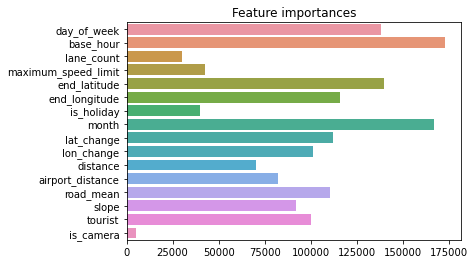

In [150]:
feature_names = X_train.columns
importances = lgb_model.feature_importances_
sns.barplot(y=feature_names, x=importances, estimator=np.mean)
plt.title("Feature importances")
plt.show()

## 추론

In [151]:
pred = lgb_model.predict(X_test)
len(pred)

291241

## Submission

In [152]:
sample_submission = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'))
sample_submission.shape

(291241, 2)

In [153]:
sub1 = sample_submission.copy()
sub1['target'] = pred

In [ ]:
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor(n_estimators=50000, 
                              boosting_type='dart',
                              num_leaves = 128, 
                              subsample=0.6,
                              colsample_bytree=0.7,
                              min_child_samples=30,
                              reg_lambda=15,
                              random_state=20)


lgb_model.fit(X_tr, y_tr,
              eval_set=[(X_val, y_val)],
              eval_metric='l1',
              verbose=500,
              early_stopping_rounds=500)    


from sklearn.metrics import mean_absolute_error
print(f"훈련 셋: {mean_absolute_error(y_tr, lgb_model.predict(X_tr))}")
print(f"검증 셋: {mean_absolute_error(y_val, lgb_model.predict(X_val))}")

[500]	valid_0's l1: 3.61567	valid_0's l2: 24.2037
[1000]	valid_0's l1: 3.33018	valid_0's l2: 21.9121
[1500]	valid_0's l1: 3.21199	valid_0's l2: 20.9814
[2000]	valid_0's l1: 3.18272	valid_0's l2: 20.6283
[2500]	valid_0's l1: 3.13304	valid_0's l2: 20.2677
[3000]	valid_0's l1: 3.12749	valid_0's l2: 20.1194
[3500]	valid_0's l1: 3.10159	valid_0's l2: 19.9432
[4000]	valid_0's l1: 3.08839	valid_0's l2: 19.8091
[4500]	valid_0's l1: 3.07311	valid_0's l2: 19.6609
[5000]	valid_0's l1: 3.06665	valid_0's l2: 19.5776
[5500]	valid_0's l1: 3.05566	valid_0's l2: 19.4688
[6000]	valid_0's l1: 3.04498	valid_0's l2: 19.3677
[6500]	valid_0's l1: 3.04354	valid_0's l2: 19.3398
[7000]	valid_0's l1: 3.03627	valid_0's l2: 19.2728
[7500]	valid_0's l1: 3.03637	valid_0's l2: 19.2286
[8000]	valid_0's l1: 3.02431	valid_0's l2: 19.1588
[8500]	valid_0's l1: 3.02327	valid_0's l2: 19.1128
[9000]	valid_0's l1: 3.0156	valid_0's l2: 19.0653
[9500]	valid_0's l1: 3.01213	valid_0's l2: 19.0259
[10000]	valid_0's l1: 3.00938	val

## 추론

In [ ]:
pred = lgb_model.predict(X_test)
len(pred)

## Submission

In [ ]:
sub2 = sample_submission.copy()
sub2['target'] = pred  

# XGBoost

In [29]:
y_train = train['target'] 

X_train = train.drop(['id','base_date', 'target', 'start_node_name', 'end_node_name', 'multi_linked', 'connect_code', 
                    'start_latitude', 'start_longitude', 
                      'start_elevation', 'end_elevation', 'center_start', 'center_end', 
                      'weight_restricted', 'road_rating_0',
                     'road_rating_1', 'road_rating_2', 'road_type_0', 'road_type_1',
                      'start_turn_restricted','end_turn_restricted',
                      'road_min', 'road_max', 'road_std',
                      'road_name', 'road_code', 'year'], axis=1)

X_test = test.drop(['id','base_date', 'start_node_name', 'end_node_name', 'multi_linked', 'connect_code', 
                    'start_latitude', 'start_longitude', 
                     'start_elevation', 'end_elevation', 'center_start', 'center_end', 
                      'weight_restricted', 'road_rating_0',
                     'road_rating_1', 'road_rating_2', 'road_type_0', 'road_type_1',
                    'start_turn_restricted','end_turn_restricted',
                    'road_min', 'road_max', 'road_std',
                      'road_name', 'road_code', 'year'], axis=1)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(4701217, 15)
(4701217,)
(291241, 15)


In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X_train)
X_train.loc[:, :] = scaler.transform(X_train)
X_test.loc[:, :] = scaler.transform(X_test)

X_test.head(2)

,base_hour,lane_count,maximum_speed_limit,end_latitude,end_longitude,is_holiday,month,lat_change,lon_change,distance,airport_distance,road_mean,slope,tourist,is_camera
0,0.754498,1.691525,0.72087,1.150794,0.141615,-0.71132,0.450723,-0.314152,-0.409113,-0.291169,-1.433274,-0.637912,-0.422688,1.174642,2.921556
1,0.010682,0.237511,0.72087,-1.247087,-0.677032,-0.71132,0.450723,0.091003,1.808738,0.990841,0.753408,0.387736,0.407955,1.174642,-0.342283


# Train-Test Split

In [33]:
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, 
                                            stratify=train['base_hour'], random_state=2021)

print(X_tr.shape, y_tr.shape)
print(X_val.shape, y_val.shape)

(3760973, 15) (3760973,)
(940244, 15) (940244,)


In [23]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(n_estimators=10000, 
                              max_depth=5, 
                              subsample=0.3,
                              colsample_bytree=0.5,
                              reg_lambda=15,
                              random_state=20)


xgb_model.fit(X_tr, y_tr,
                eval_set=[(X_val, y_val)],
                eval_metric='mae',
                verbose=100,
                early_stopping_rounds=200)    


from sklearn.metrics import mean_absolute_error
print(f"훈련 셋: {mean_absolute_error(y_tr, xgb_model.predict(X_tr))}")
print(f"검증 셋: {mean_absolute_error(y_val, xgb_model.predict(X_val))}")

[0]	validation_0-mae:29.63782
[100]	validation_0-mae:3.77718
[200]	validation_0-mae:3.61244
[300]	validation_0-mae:3.50579
[400]	validation_0-mae:3.44720
[500]	validation_0-mae:3.40746
[600]	validation_0-mae:3.37361
[700]	validation_0-mae:3.34846
[800]	validation_0-mae:3.33061
[900]	validation_0-mae:3.31381
[1000]	validation_0-mae:3.30396
[1100]	validation_0-mae:3.29214
[1200]	validation_0-mae:3.28137
[1300]	validation_0-mae:3.27284
[1400]	validation_0-mae:3.26462
[1500]	validation_0-mae:3.25707
[1600]	validation_0-mae:3.25142
[1700]	validation_0-mae:3.24613
[1800]	validation_0-mae:3.24122
[1900]	validation_0-mae:3.23727
[2000]	validation_0-mae:3.23288
[2100]	validation_0-mae:3.22824
[2200]	validation_0-mae:3.22544
[2300]	validation_0-mae:3.22228
[2400]	validation_0-mae:3.21921
[2500]	validation_0-mae:3.21686
[2600]	validation_0-mae:3.21320
[2700]	validation_0-mae:3.20971
[2800]	validation_0-mae:3.20811
[2900]	validation_0-mae:3.20598
[3000]	validation_0-mae:3.20399
[3100]	validation_0

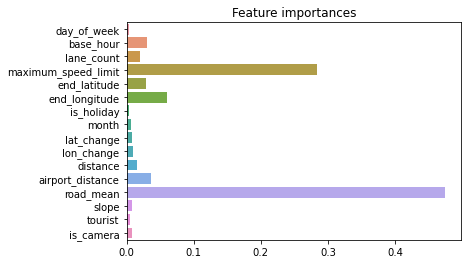

In [24]:
feature_names = X_train.columns
importances = xgb_model.feature_importances_
sns.barplot(y=feature_names, x=importances, estimator=np.mean)
plt.title("Feature importances")
plt.show()

## 추론

In [25]:
pred = xgb_model.predict(X_test)
len(pred)

291241

## Submission

In [26]:
sub3 = sample_submission.copy()
sub3['target'] = pred  

(291241, 2)

# Ensemble

In [53]:
sample_submission['target'] = np.round((sub1['target'] + sub2['target'] + sub3['target']) / 3)
sample_submission.to_csv(os.path.join(PRJ_DIR, 'submit', 'final_submission.csv'), index = False)  